In [1]:
import os, sys
import json
import random
import pickle
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
import numpy as np
from transformers import BertTokenizer, BertModel
# from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath(os.path.join(os.getcwd(),'..')))
from utils import Dataset_Reader, save_tensor, save_model, load_tensor, load_model, label_encode, max_length
from tqdm import tqdm

/home/kshitij/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/kshitij/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
with open('../data/train.json', 'r') as file:
    train_data = json.load(file)

with open('../data/dev.json', 'r') as file:
    test_data = json.load(file)

In [4]:
TRAIN_data = Dataset_Reader(train_data)
TEST_data = Dataset_Reader(test_data)
print(len(TRAIN_data))
# TRAIN_data_batched = DataLoader(TRAIN_data, batch_size = 5, shuffle= True)

247


In [11]:
def get_batched_data(data: Dataset, batch_size:int = 1) ->  Tuple[List,List,List]:
    doc_idx = []
    batched_texts = []
    batched_labels = []
    for start, stop in zip(range(0,len(data)-batch_size,batch_size), range(batch_size,len(data),batch_size)):
        idxs = []
        texts = []
        labels = []
        for idx in range(start,stop):
            idxs.append(idx) 
            [texts.append(text) for text in data[idx]['text']]
            [labels.append(label) for label in data[idx]['label']]
        
        doc_idx.append(idxs)
        batched_texts.append(texts)
        batched_labels.append(labels)
    return doc_idx, batched_texts, batched_labels

def get_model_data(data:torch.utils.data.Dataset, encoder: LabelEncoder,
                   tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                   model= BertModel.from_pretrained('bert-base-uncased'),
                   num_of_docs:int = None,
                   ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(data.labels)
    sent_emb = []
    max_sent_length = 128
    if num_of_docs is None:
        for idx, sentence in enumerate(data.texts):
            inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                padding='max_length', max_length = max_sent_length,
                                add_special_tokens= True)
            with torch.no_grad():
                output = model(**inputs)
            sent_emb.append(output.last_hidden_state[:,0,:])
    else:
        for idx, sentence in enumerate(data.texts):
            if sentence[0] < num_of_docs:
                inputs = tokenizer(sentence[2].lower(),  return_tensors="pt", truncation= True,
                                    padding='max_length', max_length = max_sent_length,
                                    add_special_tokens= True)
                with torch.no_grad():
                    output = model(**inputs)
                sent_emb.append(output.last_hidden_state[:,0,:]) 
        numerical_labels = numerical_labels[:len(sent_emb)]
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train

def get_model_data_batched(indexes:List, texts:List, labels:List, encoder:LabelEncoder,max_len_dict:Dict,
                           tokenizer= BertTokenizer.from_pretrained('bert-base-uncased'),
                           model= BertModel.from_pretrained('bert-base-uncased'),
                           ) -> Tuple[torch.TensorType, torch.TensorType]:
    numerical_labels = encoder.transform(labels)
    sent_emb = []
    for idx, sentence in enumerate(texts):
        try:
            max_sent_length = max([max_len_dict[i] for i in indexes])
        except KeyError:
            continue
        inputs = tokenizer(sentence.lower(),  return_tensors="pt", truncation= True,
                            padding='max_length', max_length = max_sent_length,
                            add_special_tokens= True)
        with torch.no_grad():
            output = model(**inputs)
        sent_emb.append(output.last_hidden_state[:,0,:])
    x_train = np.zeros((len(sent_emb), 1, 768), dtype=float)
    y_train = torch.from_numpy(numerical_labels)
    for idx, sentence in enumerate(sent_emb):
        x_train[idx] = sent_emb[idx]
    x_train = torch.from_numpy(x_train).float()
    print(f"X_train size: {x_train.size()}\tY_train size: {y_train.size()}")
    return x_train, y_train    
    

list_of_targets = ['ISSUE', 'FAC', 'NONE', 'ARG_PETITIONER', 'PRE_NOT_RELIED', 'STA', 'RPC', 'ARG_RESPONDENT', 'PREAMBLE', 'ANALYSIS', 'RLC', 'PRE_RELIED', 'RATIO']
label_encoder = label_encode(list_of_targets)

In [34]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
        
class BiLSTM(nn.Module):
    def __init__(self,
                input_size:int = 768,
                hidden_size:int = 256,
                num_layers:int = 2,
                output_size:int = 13,
                dropout:float = 0.1
                ) -> None:
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(input_size = input_size,
                              hidden_size = hidden_size//2,
                              num_layers = num_layers,
                              bidirectional=True)
        
        self.dense = nn.Sequential(nn.Dropout(p=dropout),
                                   nn.Linear(hidden_size, 128),
                                   nn.ReLU(),
                                   nn.Linear(128, output_size),
                                   nn.Softmax(dim=1),
        )
        
        self.apply(init_weights)
        
    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        lstm_out = lstm_out[:,-1,:]

        # Fully connected layers
        out = self.dense(lstm_out)

        return out

In [12]:
# TRAIN_emb, TRAIN_labels = get_model_data(data= TRAIN_data, encoder= label_encoder, num_of_docs= 10)
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)

In [37]:
def train(x_train, y_train, model, optimizer, loss_fc, num_epochs):
    model.train()
    loss_list = []
    acc_list = []
    model.train()
    # print(f'{"Starting Training":-^100}')
    for epoch in range(num_epochs+1):
        output = model(x_train)
        loss = loss_fc(output,y_train)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
        if epoch%50 == 0:
            acc = sum(output.argmax(dim=1) == y_train)/ output.size(0)
            acc_list.append(acc)
            print(f"Epoch: {epoch} \t Loss: {loss.item():.5f} \t Accuracy: {acc*100:.2f}%")
            
    return loss_list, acc_list
            
def test_accuracy(x_test, y_test, model):
    model.eval()
    output = model(x_test)
    acc = sum(output.argmax(dim=1) == y_test)/ output.size(0)
    # print(f"Test Accuracy {acc*100:.2f}%")
    return acc*100

In [ ]:
# losses, accs = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,300)

In [ ]:
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)
# test_accuracy(TEST_emb, TEST_labels, model)

In [102]:
import math
start_lr = 5e-4
end_lr = 5e-5
num_epochs = 100
lr_lambda = lambda x: math.exp(x * math.log(end_lr / start_lr) / (num_epochs * 246))
# lr_lambda = lambda x: start_lr + end_lr * math.sin(x)

model = BiLSTM(dropout=0.15, num_layers=1)
model_opt = torch.optim.Adam(model.parameters(), lr= start_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(model_opt, lr_lambda)
loss_function = nn.CrossEntropyLoss()

In [97]:
# x = list(range(10*246))
# y = [start_lr + end_lr * math.sin(i) for i in x]
# sns.lineplot(x,y)

In [103]:
batch_loss, batch_acc, lr_list = [], [], []
# batch_counter = 0
# random_doc_indexes = random.sample([i for i in range(len(batched_texts))],k=10)
# print(random_doc_indexes)
print(f'{"Starting Training":-^100}')
model.train()
for epoch in range(num_epochs):
    # print(f"Epoch {epoch}")
    for idx in tqdm(range(246)):
        TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
        TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
        if TRAIN_emb.size(0) == 0:
            continue
        output = model(TRAIN_emb)
        loss = loss_function(output,TRAIN_labels)
        
        model_opt.zero_grad()
        loss.backward()
        model_opt.step()
        scheduler.step()
        batch_loss.append(loss.item())
        lr_step = model_opt.state_dict()["param_groups"][0]["lr"]
        lr_list.append(lr_step)
        
    print(f"Epoch: {epoch+1} \t Loss: {loss.item():.5f}")
    

    # # batch_counter += 1
    # # print(f"{f'BATCH NUMBER {batch_counter}':-^100}")
    #     TRAIN_emb = load_tensor(filepath=f"../train_document/doc_{idx}/embedding")
    #     TRAIN_labels = load_tensor(filepath=f"../train_document/doc_{idx}/label")
    #     if TRAIN_emb.size(0) == 0:
    #         continue
    #     # TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx],batched_texts[idx],batched_labels[idx],label_encoder,max_lens_train)
    #     loss, acc = train(TRAIN_emb,TRAIN_labels,model,model_opt,loss_function,1)
    #     batch_loss.append(loss)
    #     batch_acc.append(acc)
    #     del TRAIN_emb, TRAIN_labels

-----------------------------------------Starting Training------------------------------------------


100%|██████████| 246/246 [00:06<00:00, 38.56it/s]


Epoch: 1 	 Loss: 2.23684


100%|██████████| 246/246 [00:05<00:00, 43.61it/s]


Epoch: 2 	 Loss: 2.16217


100%|██████████| 246/246 [00:05<00:00, 44.17it/s]


Epoch: 3 	 Loss: 2.11336


100%|██████████| 246/246 [00:06<00:00, 40.82it/s]


Epoch: 4 	 Loss: 2.23034


100%|██████████| 246/246 [00:05<00:00, 43.25it/s]


Epoch: 5 	 Loss: 2.02064


100%|██████████| 246/246 [00:05<00:00, 41.91it/s]


Epoch: 6 	 Loss: 2.04975


100%|██████████| 246/246 [00:05<00:00, 42.46it/s]


Epoch: 7 	 Loss: 2.01172


100%|██████████| 246/246 [00:05<00:00, 42.46it/s]


Epoch: 8 	 Loss: 2.06973


100%|██████████| 246/246 [00:05<00:00, 43.46it/s]


Epoch: 9 	 Loss: 2.00349


100%|██████████| 246/246 [00:05<00:00, 44.27it/s]


Epoch: 10 	 Loss: 1.94726


100%|██████████| 246/246 [00:05<00:00, 42.83it/s]


Epoch: 11 	 Loss: 1.96512


100%|██████████| 246/246 [00:05<00:00, 43.08it/s]


Epoch: 12 	 Loss: 1.96058


100%|██████████| 246/246 [00:05<00:00, 43.37it/s]


Epoch: 13 	 Loss: 1.96722


100%|██████████| 246/246 [00:05<00:00, 42.57it/s]


Epoch: 14 	 Loss: 1.99656


100%|██████████| 246/246 [00:05<00:00, 42.28it/s]


Epoch: 15 	 Loss: 1.91897


100%|██████████| 246/246 [00:05<00:00, 42.30it/s]


Epoch: 16 	 Loss: 1.93900


100%|██████████| 246/246 [00:05<00:00, 44.73it/s]


Epoch: 17 	 Loss: 1.91912


100%|██████████| 246/246 [00:05<00:00, 44.87it/s]


Epoch: 18 	 Loss: 1.88894


100%|██████████| 246/246 [00:05<00:00, 43.50it/s]


Epoch: 19 	 Loss: 1.89509


100%|██████████| 246/246 [00:05<00:00, 44.34it/s]


Epoch: 20 	 Loss: 1.86232


100%|██████████| 246/246 [00:05<00:00, 44.48it/s]


Epoch: 21 	 Loss: 1.86909


100%|██████████| 246/246 [00:05<00:00, 42.53it/s]


Epoch: 22 	 Loss: 1.86138


100%|██████████| 246/246 [00:05<00:00, 42.76it/s]


Epoch: 23 	 Loss: 1.86241


100%|██████████| 246/246 [00:05<00:00, 44.73it/s]


Epoch: 24 	 Loss: 1.86349


100%|██████████| 246/246 [00:05<00:00, 42.51it/s]


Epoch: 25 	 Loss: 1.86563


100%|██████████| 246/246 [00:05<00:00, 42.33it/s]


Epoch: 26 	 Loss: 1.86183


100%|██████████| 246/246 [00:06<00:00, 39.92it/s]


Epoch: 27 	 Loss: 1.86235


100%|██████████| 246/246 [00:05<00:00, 43.39it/s]


Epoch: 28 	 Loss: 1.86180


100%|██████████| 246/246 [00:05<00:00, 42.91it/s]


Epoch: 29 	 Loss: 1.86913


100%|██████████| 246/246 [00:05<00:00, 43.91it/s]


Epoch: 30 	 Loss: 1.86315


100%|██████████| 246/246 [00:05<00:00, 44.17it/s]


Epoch: 31 	 Loss: 1.86194


100%|██████████| 246/246 [00:06<00:00, 40.87it/s]


Epoch: 32 	 Loss: 1.86177


100%|██████████| 246/246 [00:05<00:00, 42.80it/s]


Epoch: 33 	 Loss: 1.86739


100%|██████████| 246/246 [00:05<00:00, 43.96it/s]


Epoch: 34 	 Loss: 1.86141


100%|██████████| 246/246 [00:05<00:00, 41.13it/s]


Epoch: 35 	 Loss: 1.86132


100%|██████████| 246/246 [00:06<00:00, 37.07it/s]


Epoch: 36 	 Loss: 1.86206


100%|██████████| 246/246 [00:05<00:00, 42.80it/s]


Epoch: 37 	 Loss: 1.86205


100%|██████████| 246/246 [00:05<00:00, 42.34it/s]


Epoch: 38 	 Loss: 1.86282


100%|██████████| 246/246 [00:05<00:00, 44.60it/s]


Epoch: 39 	 Loss: 1.86297


100%|██████████| 246/246 [00:05<00:00, 43.16it/s]


Epoch: 40 	 Loss: 1.86161


100%|██████████| 246/246 [00:05<00:00, 41.11it/s]


Epoch: 41 	 Loss: 1.86266


100%|██████████| 246/246 [00:05<00:00, 42.04it/s]


Epoch: 42 	 Loss: 1.86213


100%|██████████| 246/246 [00:05<00:00, 43.61it/s]


Epoch: 43 	 Loss: 1.86254


100%|██████████| 246/246 [00:05<00:00, 42.03it/s]


Epoch: 44 	 Loss: 1.87335


100%|██████████| 246/246 [00:05<00:00, 42.31it/s]


Epoch: 45 	 Loss: 1.86187


100%|██████████| 246/246 [00:05<00:00, 43.99it/s]


Epoch: 46 	 Loss: 1.86247


100%|██████████| 246/246 [00:05<00:00, 44.38it/s]


Epoch: 47 	 Loss: 1.86207


100%|██████████| 246/246 [00:05<00:00, 41.42it/s]


Epoch: 48 	 Loss: 1.86176


100%|██████████| 246/246 [00:05<00:00, 44.64it/s]


Epoch: 49 	 Loss: 1.84877


100%|██████████| 246/246 [00:05<00:00, 44.05it/s]


Epoch: 50 	 Loss: 1.84388


100%|██████████| 246/246 [00:05<00:00, 43.42it/s]


Epoch: 51 	 Loss: 1.83883


100%|██████████| 246/246 [00:05<00:00, 43.84it/s]


Epoch: 52 	 Loss: 1.83945


100%|██████████| 246/246 [00:05<00:00, 43.77it/s]


Epoch: 53 	 Loss: 1.83742


100%|██████████| 246/246 [00:05<00:00, 45.08it/s]


Epoch: 54 	 Loss: 1.83757


100%|██████████| 246/246 [00:05<00:00, 43.01it/s]


Epoch: 55 	 Loss: 1.83737


100%|██████████| 246/246 [00:05<00:00, 42.72it/s]


Epoch: 56 	 Loss: 1.83914


100%|██████████| 246/246 [00:05<00:00, 43.93it/s]


Epoch: 57 	 Loss: 1.83836


100%|██████████| 246/246 [00:06<00:00, 40.89it/s]


Epoch: 58 	 Loss: 1.83767


100%|██████████| 246/246 [00:07<00:00, 31.14it/s]


Epoch: 59 	 Loss: 1.83842


100%|██████████| 246/246 [00:05<00:00, 43.33it/s]


Epoch: 60 	 Loss: 1.83887


100%|██████████| 246/246 [00:05<00:00, 44.28it/s]


Epoch: 61 	 Loss: 1.83734


100%|██████████| 246/246 [00:05<00:00, 44.80it/s]


Epoch: 62 	 Loss: 1.83713


100%|██████████| 246/246 [00:05<00:00, 42.50it/s]


Epoch: 63 	 Loss: 1.83828


100%|██████████| 246/246 [00:05<00:00, 44.10it/s]


Epoch: 64 	 Loss: 1.83725


100%|██████████| 246/246 [00:05<00:00, 44.52it/s]


Epoch: 65 	 Loss: 1.84018


100%|██████████| 246/246 [00:05<00:00, 42.89it/s]


Epoch: 66 	 Loss: 1.83851


100%|██████████| 246/246 [00:05<00:00, 42.53it/s]


Epoch: 67 	 Loss: 1.83767


100%|██████████| 246/246 [00:06<00:00, 39.92it/s]


Epoch: 68 	 Loss: 1.83757


100%|██████████| 246/246 [00:06<00:00, 40.78it/s]


Epoch: 69 	 Loss: 1.83842


100%|██████████| 246/246 [00:05<00:00, 41.67it/s]


Epoch: 70 	 Loss: 1.83697


100%|██████████| 246/246 [00:05<00:00, 43.34it/s]


Epoch: 71 	 Loss: 1.83853


100%|██████████| 246/246 [00:05<00:00, 42.62it/s]


Epoch: 72 	 Loss: 1.83803


100%|██████████| 246/246 [00:05<00:00, 43.22it/s]


Epoch: 73 	 Loss: 1.83767


100%|██████████| 246/246 [00:05<00:00, 41.56it/s]


Epoch: 74 	 Loss: 1.83737


100%|██████████| 246/246 [00:05<00:00, 42.88it/s]


Epoch: 75 	 Loss: 1.83717


100%|██████████| 246/246 [00:05<00:00, 41.31it/s]


Epoch: 76 	 Loss: 1.83752


100%|██████████| 246/246 [00:05<00:00, 41.02it/s]


Epoch: 77 	 Loss: 1.83704


100%|██████████| 246/246 [00:05<00:00, 42.25it/s]


Epoch: 78 	 Loss: 1.83771


100%|██████████| 246/246 [00:05<00:00, 42.78it/s]


Epoch: 79 	 Loss: 1.83705


100%|██████████| 246/246 [00:06<00:00, 40.02it/s]


Epoch: 80 	 Loss: 1.83680


100%|██████████| 246/246 [00:05<00:00, 42.94it/s]


Epoch: 81 	 Loss: 1.83706


100%|██████████| 246/246 [00:05<00:00, 43.02it/s]


Epoch: 82 	 Loss: 1.83955


100%|██████████| 246/246 [00:05<00:00, 42.15it/s]


Epoch: 83 	 Loss: 1.83916


100%|██████████| 246/246 [00:07<00:00, 34.39it/s]


Epoch: 84 	 Loss: 1.83855


100%|██████████| 246/246 [00:05<00:00, 42.29it/s]


Epoch: 85 	 Loss: 1.83831


100%|██████████| 246/246 [00:05<00:00, 42.76it/s]


Epoch: 86 	 Loss: 1.83957


100%|██████████| 246/246 [00:05<00:00, 41.01it/s]


Epoch: 87 	 Loss: 1.84049


100%|██████████| 246/246 [00:05<00:00, 43.31it/s]


Epoch: 88 	 Loss: 1.83665


100%|██████████| 246/246 [00:05<00:00, 42.67it/s]


Epoch: 89 	 Loss: 1.83927


100%|██████████| 246/246 [00:06<00:00, 36.50it/s]


Epoch: 90 	 Loss: 1.83853


100%|██████████| 246/246 [00:06<00:00, 38.65it/s]


Epoch: 91 	 Loss: 1.84084


100%|██████████| 246/246 [00:05<00:00, 42.13it/s]


Epoch: 92 	 Loss: 1.83752


100%|██████████| 246/246 [00:05<00:00, 43.02it/s]


Epoch: 93 	 Loss: 1.83698


100%|██████████| 246/246 [00:06<00:00, 39.18it/s]


Epoch: 94 	 Loss: 1.83758


100%|██████████| 246/246 [00:05<00:00, 42.34it/s]


Epoch: 95 	 Loss: 1.83754


100%|██████████| 246/246 [00:05<00:00, 42.23it/s]


Epoch: 96 	 Loss: 1.83686


100%|██████████| 246/246 [00:05<00:00, 42.41it/s]


Epoch: 97 	 Loss: 1.83707


100%|██████████| 246/246 [00:05<00:00, 41.31it/s]


Epoch: 98 	 Loss: 1.83764


100%|██████████| 246/246 [00:05<00:00, 42.40it/s]


Epoch: 99 	 Loss: 1.83854


100%|██████████| 246/246 [00:05<00:00, 41.49it/s]

Epoch: 100 	 Loss: 1.83721


In [24]:
save_model(model, "../models/BiLSTM.pth")

Model parameters saved to '../models/BiLSTM.pth'


In [104]:
# TEST_emb, TEST_labels = get_model_data(data= TEST_data, encoder= label_encoder,num_of_docs= 5)
acc = 0
for i in range(29):
    TEST_emb = load_tensor(filepath=f"../test_document/doc_{i}/embedding")
    TEST_labels = load_tensor(filepath=f"../test_document/doc_{i}/label")
    acc += test_accuracy(TEST_emb, TEST_labels, model)
    
print(acc/29)

tensor(78.0811)


In [35]:
test_accuracy(TEST_emb, TEST_labels, model)

Test Accuracy 82.29%


In [108]:
# accs_plot = [acc[-1].item() for acc in batch_acc]
# loss_plot = [np.mean(loss[-5:]) for loss in batch_loss]

In [39]:
import seaborn as sns

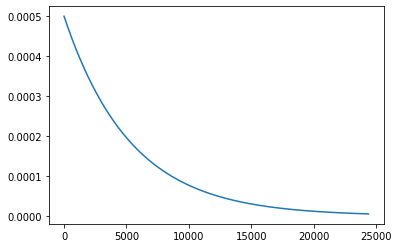

In [105]:
sns.lineplot(x= range(len(lr_list)),y= lr_list);

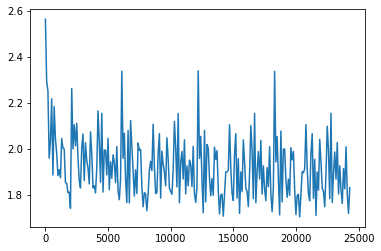

In [106]:
sns.lineplot(x= range(0,len(batch_loss),100), y= batch_loss[::100]);

# -------------------------------------------------

# Saving document embeddings

In [13]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TRAIN_data, batch_size= 1)
max_lens_train = max_length(TRAIN_data, tokenizer)

In [14]:
for idx in tqdm(range(len(doc_idxs))):
    TRAIN_emb, TRAIN_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_train)
    save_tensor(TRAIN_emb, '../train_document/doc_'+str(idx),"embedding")
    save_tensor(TRAIN_labels, '../train_document/doc_'+str(idx),"label")

  0%|          | 1/246 [00:27<1:51:56, 27.41s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])


  1%|          | 2/246 [00:58<1:59:19, 29.34s/it]

X_train size: torch.Size([72, 1, 768])	Y_train size: torch.Size([72])


  1%|          | 3/246 [03:15<5:17:56, 78.51s/it]

X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])


  2%|▏         | 4/246 [04:31<5:14:03, 77.86s/it]

X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])


  2%|▏         | 5/246 [06:37<6:21:44, 95.04s/it]

X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])


  2%|▏         | 6/246 [07:38<5:34:30, 83.63s/it]

X_train size: torch.Size([211, 1, 768])	Y_train size: torch.Size([211])


  3%|▎         | 7/246 [08:52<5:20:33, 80.48s/it]

X_train size: torch.Size([140, 1, 768])	Y_train size: torch.Size([140])


  3%|▎         | 8/246 [09:17<4:08:58, 62.77s/it]

X_train size: torch.Size([87, 1, 768])	Y_train size: torch.Size([87])


  4%|▎         | 9/246 [10:41<4:34:17, 69.44s/it]

X_train size: torch.Size([228, 1, 768])	Y_train size: torch.Size([228])


  4%|▍         | 10/246 [11:24<4:01:07, 61.30s/it]

X_train size: torch.Size([99, 1, 768])	Y_train size: torch.Size([99])


  4%|▍         | 11/246 [11:41<3:06:56, 47.73s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])


  5%|▍         | 12/246 [13:14<3:59:14, 61.35s/it]

X_train size: torch.Size([213, 1, 768])	Y_train size: torch.Size([213])


  5%|▌         | 13/246 [14:01<3:41:24, 57.02s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])


  6%|▌         | 14/246 [16:38<5:37:32, 87.29s/it]

X_train size: torch.Size([199, 1, 768])	Y_train size: torch.Size([199])


  6%|▌         | 15/246 [18:30<6:04:15, 94.61s/it]

X_train size: torch.Size([188, 1, 768])	Y_train size: torch.Size([188])


  7%|▋         | 16/246 [24:31<11:10:01, 174.79s/it]

X_train size: torch.Size([271, 1, 768])	Y_train size: torch.Size([271])


  7%|▋         | 17/246 [24:46<8:03:58, 126.80s/it] 

X_train size: torch.Size([43, 1, 768])	Y_train size: torch.Size([43])


  7%|▋         | 18/246 [25:19<6:14:31, 98.56s/it] 

X_train size: torch.Size([82, 1, 768])	Y_train size: torch.Size([82])


  8%|▊         | 19/246 [26:30<5:41:20, 90.22s/it]

X_train size: torch.Size([171, 1, 768])	Y_train size: torch.Size([171])


  8%|▊         | 20/246 [29:17<7:06:56, 113.35s/it]

X_train size: torch.Size([149, 1, 768])	Y_train size: torch.Size([149])


  9%|▊         | 21/246 [30:15<6:02:45, 96.73s/it] 

X_train size: torch.Size([95, 1, 768])	Y_train size: torch.Size([95])


  9%|▉         | 22/246 [30:49<4:50:33, 77.83s/it]

X_train size: torch.Size([56, 1, 768])	Y_train size: torch.Size([56])


  9%|▉         | 23/246 [31:07<3:43:08, 60.04s/it]

X_train size: torch.Size([47, 1, 768])	Y_train size: torch.Size([47])


 10%|▉         | 24/246 [31:57<3:31:11, 57.08s/it]

X_train size: torch.Size([116, 1, 768])	Y_train size: torch.Size([116])


 10%|█         | 25/246 [32:40<3:14:28, 52.80s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])


 11%|█         | 26/246 [33:05<2:43:08, 44.49s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])


 11%|█         | 27/246 [34:39<3:36:21, 59.27s/it]

X_train size: torch.Size([109, 1, 768])	Y_train size: torch.Size([109])


 11%|█▏        | 28/246 [35:36<3:33:14, 58.69s/it]

X_train size: torch.Size([155, 1, 768])	Y_train size: torch.Size([155])


 12%|█▏        | 29/246 [37:02<4:01:20, 66.73s/it]

X_train size: torch.Size([198, 1, 768])	Y_train size: torch.Size([198])


 12%|█▏        | 30/246 [39:11<5:08:03, 85.57s/it]

X_train size: torch.Size([153, 1, 768])	Y_train size: torch.Size([153])


 13%|█▎        | 31/246 [39:45<4:11:14, 70.12s/it]

X_train size: torch.Size([50, 1, 768])	Y_train size: torch.Size([50])


 13%|█▎        | 32/246 [40:04<3:14:47, 54.61s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])


 13%|█▎        | 33/246 [42:03<4:23:01, 74.09s/it]

X_train size: torch.Size([264, 1, 768])	Y_train size: torch.Size([264])


 14%|█▍        | 34/246 [42:51<3:53:54, 66.20s/it]

X_train size: torch.Size([114, 1, 768])	Y_train size: torch.Size([114])


 14%|█▍        | 35/246 [43:19<3:12:36, 54.77s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])


 15%|█▍        | 36/246 [45:15<4:15:24, 72.98s/it]

X_train size: torch.Size([243, 1, 768])	Y_train size: torch.Size([243])


 15%|█▌        | 37/246 [46:32<4:18:27, 74.20s/it]

X_train size: torch.Size([107, 1, 768])	Y_train size: torch.Size([107])


 15%|█▌        | 38/246 [47:55<4:26:57, 77.01s/it]

X_train size: torch.Size([127, 1, 768])	Y_train size: torch.Size([127])


 16%|█▌        | 39/246 [49:53<5:07:19, 89.08s/it]

X_train size: torch.Size([188, 1, 768])	Y_train size: torch.Size([188])


 16%|█▋        | 40/246 [51:10<4:53:57, 85.62s/it]

X_train size: torch.Size([189, 1, 768])	Y_train size: torch.Size([189])


 17%|█▋        | 41/246 [52:22<4:38:23, 81.48s/it]

X_train size: torch.Size([157, 1, 768])	Y_train size: torch.Size([157])


 17%|█▋        | 42/246 [52:38<3:30:28, 61.90s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])


 17%|█▋        | 43/246 [53:19<3:08:29, 55.71s/it]

X_train size: torch.Size([120, 1, 768])	Y_train size: torch.Size([120])


 18%|█▊        | 44/246 [54:36<3:28:22, 61.89s/it]

X_train size: torch.Size([142, 1, 768])	Y_train size: torch.Size([142])


 18%|█▊        | 45/246 [55:12<3:01:03, 54.05s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])


 19%|█▊        | 46/246 [56:10<3:04:13, 55.27s/it]

X_train size: torch.Size([146, 1, 768])	Y_train size: torch.Size([146])


 19%|█▉        | 47/246 [57:29<3:26:50, 62.37s/it]

X_train size: torch.Size([185, 1, 768])	Y_train size: torch.Size([185])


 20%|█▉        | 48/246 [57:48<2:43:37, 49.58s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])


 20%|█▉        | 49/246 [58:06<2:10:56, 39.88s/it]

X_train size: torch.Size([73, 1, 768])	Y_train size: torch.Size([73])


 20%|██        | 50/246 [58:38<2:03:13, 37.72s/it]

X_train size: torch.Size([79, 1, 768])	Y_train size: torch.Size([79])


 21%|██        | 51/246 [59:53<2:38:31, 48.78s/it]

X_train size: torch.Size([187, 1, 768])	Y_train size: torch.Size([187])


 21%|██        | 52/246 [1:00:35<2:31:20, 46.81s/it]

X_train size: torch.Size([82, 1, 768])	Y_train size: torch.Size([82])


 22%|██▏       | 53/246 [1:01:11<2:20:31, 43.69s/it]

X_train size: torch.Size([88, 1, 768])	Y_train size: torch.Size([88])


 22%|██▏       | 54/246 [1:01:47<2:12:16, 41.33s/it]

X_train size: torch.Size([59, 1, 768])	Y_train size: torch.Size([59])


 22%|██▏       | 55/246 [1:02:10<1:54:08, 35.86s/it]

X_train size: torch.Size([59, 1, 768])	Y_train size: torch.Size([59])


 23%|██▎       | 56/246 [1:02:54<2:00:46, 38.14s/it]

X_train size: torch.Size([110, 1, 768])	Y_train size: torch.Size([110])


 23%|██▎       | 57/246 [1:04:04<2:30:20, 47.73s/it]

X_train size: torch.Size([141, 1, 768])	Y_train size: torch.Size([141])


 24%|██▎       | 58/246 [1:04:26<2:05:11, 39.95s/it]

X_train size: torch.Size([31, 1, 768])	Y_train size: torch.Size([31])


 24%|██▍       | 59/246 [1:04:41<1:41:19, 32.51s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])


 24%|██▍       | 60/246 [1:05:03<1:31:03, 29.37s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])


 25%|██▍       | 61/246 [1:05:21<1:20:31, 26.12s/it]

X_train size: torch.Size([31, 1, 768])	Y_train size: torch.Size([31])


 25%|██▌       | 62/246 [1:05:35<1:08:09, 22.23s/it]

X_train size: torch.Size([39, 1, 768])	Y_train size: torch.Size([39])


 26%|██▌       | 63/246 [1:08:06<3:05:44, 60.90s/it]

X_train size: torch.Size([208, 1, 768])	Y_train size: torch.Size([208])


 26%|██▌       | 64/246 [1:09:16<3:12:59, 63.62s/it]

X_train size: torch.Size([115, 1, 768])	Y_train size: torch.Size([115])


 26%|██▋       | 65/246 [1:11:38<4:22:46, 87.11s/it]

X_train size: torch.Size([155, 1, 768])	Y_train size: torch.Size([155])


 27%|██▋       | 66/246 [1:12:44<4:02:32, 80.85s/it]

X_train size: torch.Size([123, 1, 768])	Y_train size: torch.Size([123])


 27%|██▋       | 67/246 [1:13:15<3:16:47, 65.96s/it]

X_train size: torch.Size([52, 1, 768])	Y_train size: torch.Size([52])


 28%|██▊       | 68/246 [1:14:25<3:19:32, 67.26s/it]

X_train size: torch.Size([143, 1, 768])	Y_train size: torch.Size([143])


 28%|██▊       | 69/246 [1:16:39<4:16:53, 87.08s/it]

X_train size: torch.Size([142, 1, 768])	Y_train size: torch.Size([142])
X_train size: torch.Size([0, 1, 768])	Y_train size: torch.Size([0])


 29%|██▉       | 71/246 [1:17:02<2:32:20, 52.23s/it]

X_train size: torch.Size([77, 1, 768])	Y_train size: torch.Size([77])


 29%|██▉       | 72/246 [1:17:42<2:23:00, 49.31s/it]

X_train size: torch.Size([116, 1, 768])	Y_train size: torch.Size([116])


 30%|██▉       | 73/246 [1:18:52<2:37:34, 54.65s/it]

X_train size: torch.Size([87, 1, 768])	Y_train size: torch.Size([87])


 30%|███       | 74/246 [1:20:05<2:50:41, 59.55s/it]

X_train size: torch.Size([122, 1, 768])	Y_train size: torch.Size([122])


 30%|███       | 75/246 [1:21:00<2:46:05, 58.28s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])


 31%|███       | 76/246 [1:22:03<2:49:34, 59.85s/it]

X_train size: torch.Size([95, 1, 768])	Y_train size: torch.Size([95])


 31%|███▏      | 77/246 [1:23:46<3:23:34, 72.28s/it]

X_train size: torch.Size([184, 1, 768])	Y_train size: torch.Size([184])


 32%|███▏      | 78/246 [1:24:52<3:17:03, 70.38s/it]

X_train size: torch.Size([144, 1, 768])	Y_train size: torch.Size([144])


 32%|███▏      | 79/246 [1:25:10<2:33:05, 55.00s/it]

X_train size: torch.Size([35, 1, 768])	Y_train size: torch.Size([35])


 33%|███▎      | 80/246 [1:26:51<3:09:52, 68.63s/it]

X_train size: torch.Size([140, 1, 768])	Y_train size: torch.Size([140])


 33%|███▎      | 81/246 [1:27:12<2:29:36, 54.40s/it]

X_train size: torch.Size([73, 1, 768])	Y_train size: torch.Size([73])


 33%|███▎      | 82/246 [1:29:50<3:52:56, 85.22s/it]

X_train size: torch.Size([137, 1, 768])	Y_train size: torch.Size([137])


 34%|███▎      | 83/246 [1:30:01<2:51:51, 63.26s/it]

X_train size: torch.Size([24, 1, 768])	Y_train size: torch.Size([24])


 34%|███▍      | 84/246 [1:31:52<3:28:56, 77.38s/it]

X_train size: torch.Size([113, 1, 768])	Y_train size: torch.Size([113])


 35%|███▍      | 85/246 [1:32:30<2:55:44, 65.50s/it]

X_train size: torch.Size([105, 1, 768])	Y_train size: torch.Size([105])


 35%|███▍      | 86/246 [1:32:59<2:25:57, 54.74s/it]

X_train size: torch.Size([80, 1, 768])	Y_train size: torch.Size([80])


 35%|███▌      | 87/246 [1:33:55<2:25:36, 54.95s/it]

X_train size: torch.Size([106, 1, 768])	Y_train size: torch.Size([106])


 36%|███▌      | 88/246 [1:34:22<2:03:16, 46.81s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])


 36%|███▌      | 89/246 [1:35:18<2:09:17, 49.41s/it]

X_train size: torch.Size([105, 1, 768])	Y_train size: torch.Size([105])


 37%|███▋      | 90/246 [1:35:37<1:44:37, 40.24s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])


 37%|███▋      | 91/246 [1:37:03<2:19:18, 53.92s/it]

X_train size: torch.Size([136, 1, 768])	Y_train size: torch.Size([136])


 37%|███▋      | 92/246 [1:37:42<2:07:28, 49.67s/it]

X_train size: torch.Size([83, 1, 768])	Y_train size: torch.Size([83])


 38%|███▊      | 93/246 [1:39:46<3:03:13, 71.85s/it]

X_train size: torch.Size([221, 1, 768])	Y_train size: torch.Size([221])


 38%|███▊      | 94/246 [1:40:49<2:55:03, 69.10s/it]

X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])


 39%|███▊      | 95/246 [1:42:08<3:01:44, 72.22s/it]

X_train size: torch.Size([114, 1, 768])	Y_train size: torch.Size([114])


 39%|███▉      | 96/246 [1:42:40<2:30:02, 60.02s/it]

X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])


 39%|███▉      | 97/246 [1:43:03<2:01:18, 48.85s/it]

X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])


 40%|███▉      | 98/246 [1:43:43<1:54:21, 46.36s/it]

X_train size: torch.Size([70, 1, 768])	Y_train size: torch.Size([70])


 40%|████      | 99/246 [1:45:32<2:39:40, 65.17s/it]

X_train size: torch.Size([264, 1, 768])	Y_train size: torch.Size([264])


 41%|████      | 100/246 [1:47:49<3:30:50, 86.65s/it]

X_train size: torch.Size([167, 1, 768])	Y_train size: torch.Size([167])


 41%|████      | 101/246 [1:48:06<2:38:47, 65.71s/it]

X_train size: torch.Size([49, 1, 768])	Y_train size: torch.Size([49])


 41%|████▏     | 102/246 [1:48:45<2:18:34, 57.74s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])


 42%|████▏     | 103/246 [1:49:06<1:51:25, 46.75s/it]

X_train size: torch.Size([74, 1, 768])	Y_train size: torch.Size([74])


 42%|████▏     | 104/246 [1:50:27<2:14:57, 57.03s/it]

X_train size: torch.Size([123, 1, 768])	Y_train size: torch.Size([123])


 43%|████▎     | 105/246 [1:51:32<2:19:54, 59.54s/it]

X_train size: torch.Size([147, 1, 768])	Y_train size: torch.Size([147])


 43%|████▎     | 106/246 [1:53:17<2:50:34, 73.10s/it]

X_train size: torch.Size([180, 1, 768])	Y_train size: torch.Size([180])


 43%|████▎     | 107/246 [1:53:55<2:24:45, 62.49s/it]

X_train size: torch.Size([71, 1, 768])	Y_train size: torch.Size([71])


 44%|████▍     | 108/246 [1:55:15<2:36:02, 67.84s/it]

X_train size: torch.Size([174, 1, 768])	Y_train size: torch.Size([174])


 44%|████▍     | 109/246 [1:56:18<2:31:37, 66.41s/it]

X_train size: torch.Size([126, 1, 768])	Y_train size: torch.Size([126])


 45%|████▍     | 110/246 [1:57:09<2:19:45, 61.66s/it]

X_train size: torch.Size([129, 1, 768])	Y_train size: torch.Size([129])


 45%|████▌     | 111/246 [1:57:25<1:48:00, 48.00s/it]

X_train size: torch.Size([32, 1, 768])	Y_train size: torch.Size([32])


 46%|████▌     | 112/246 [1:58:11<1:45:48, 47.38s/it]

X_train size: torch.Size([121, 1, 768])	Y_train size: torch.Size([121])


 46%|████▌     | 113/246 [1:58:41<1:33:31, 42.19s/it]

X_train size: torch.Size([60, 1, 768])	Y_train size: torch.Size([60])


 46%|████▋     | 114/246 [1:59:53<1:52:12, 51.00s/it]

X_train size: torch.Size([94, 1, 768])	Y_train size: torch.Size([94])


 47%|████▋     | 115/246 [2:00:37<1:47:05, 49.05s/it]

X_train size: torch.Size([121, 1, 768])	Y_train size: torch.Size([121])


 47%|████▋     | 116/246 [2:01:26<1:46:28, 49.14s/it]

X_train size: torch.Size([115, 1, 768])	Y_train size: torch.Size([115])


 48%|████▊     | 117/246 [2:03:27<2:31:59, 70.69s/it]

X_train size: torch.Size([153, 1, 768])	Y_train size: torch.Size([153])


 48%|████▊     | 118/246 [2:05:35<3:07:25, 87.85s/it]

X_train size: torch.Size([308, 1, 768])	Y_train size: torch.Size([308])


 48%|████▊     | 119/246 [2:06:03<2:27:47, 69.82s/it]

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])


 49%|████▉     | 120/246 [2:07:05<2:21:41, 67.47s/it]

X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])


 49%|████▉     | 121/246 [2:08:05<2:16:02, 65.30s/it]

X_train size: torch.Size([71, 1, 768])	Y_train size: torch.Size([71])


 50%|████▉     | 122/246 [2:09:04<2:11:04, 63.42s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])


 50%|█████     | 123/246 [2:11:25<2:57:37, 86.65s/it]

X_train size: torch.Size([201, 1, 768])	Y_train size: torch.Size([201])


 50%|█████     | 124/246 [2:11:54<2:20:43, 69.21s/it]

X_train size: torch.Size([31, 1, 768])	Y_train size: torch.Size([31])


 51%|█████     | 125/246 [2:14:28<3:10:56, 94.68s/it]

X_train size: torch.Size([168, 1, 768])	Y_train size: torch.Size([168])


 51%|█████     | 126/246 [2:16:47<3:35:50, 107.92s/it]

X_train size: torch.Size([213, 1, 768])	Y_train size: torch.Size([213])


 52%|█████▏    | 127/246 [2:17:35<2:58:41, 90.09s/it] 

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])


 52%|█████▏    | 128/246 [2:19:41<3:18:02, 100.70s/it]

X_train size: torch.Size([85, 1, 768])	Y_train size: torch.Size([85])


 52%|█████▏    | 129/246 [2:23:58<4:48:16, 147.84s/it]

X_train size: torch.Size([174, 1, 768])	Y_train size: torch.Size([174])


 53%|█████▎    | 130/246 [2:25:13<4:03:25, 125.91s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])


 53%|█████▎    | 131/246 [2:27:34<4:10:03, 130.47s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])


 54%|█████▎    | 132/246 [2:31:51<5:19:57, 168.40s/it]

X_train size: torch.Size([130, 1, 768])	Y_train size: torch.Size([130])


 54%|█████▍    | 133/246 [2:34:32<5:13:02, 166.22s/it]

X_train size: torch.Size([126, 1, 768])	Y_train size: torch.Size([126])


 54%|█████▍    | 134/246 [2:36:20<4:37:48, 148.83s/it]

X_train size: torch.Size([158, 1, 768])	Y_train size: torch.Size([158])


 55%|█████▍    | 135/246 [2:38:02<4:09:09, 134.68s/it]

X_train size: torch.Size([103, 1, 768])	Y_train size: torch.Size([103])


 55%|█████▌    | 136/246 [2:40:31<4:14:32, 138.85s/it]

X_train size: torch.Size([130, 1, 768])	Y_train size: torch.Size([130])


 56%|█████▌    | 137/246 [2:42:02<3:46:32, 124.70s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])


 56%|█████▌    | 138/246 [2:44:05<3:43:18, 124.06s/it]

X_train size: torch.Size([98, 1, 768])	Y_train size: torch.Size([98])


 57%|█████▋    | 139/246 [2:47:07<4:12:02, 141.33s/it]

X_train size: torch.Size([161, 1, 768])	Y_train size: torch.Size([161])


 57%|█████▋    | 140/246 [2:48:35<3:41:45, 125.52s/it]

X_train size: torch.Size([93, 1, 768])	Y_train size: torch.Size([93])


 57%|█████▋    | 141/246 [2:49:56<3:16:10, 112.10s/it]

X_train size: torch.Size([67, 1, 768])	Y_train size: torch.Size([67])


 58%|█████▊    | 142/246 [2:52:51<3:46:51, 130.88s/it]

X_train size: torch.Size([173, 1, 768])	Y_train size: torch.Size([173])


 58%|█████▊    | 143/246 [2:55:35<4:01:42, 140.80s/it]

X_train size: torch.Size([234, 1, 768])	Y_train size: torch.Size([234])


 59%|█████▊    | 144/246 [2:59:40<4:52:33, 172.10s/it]

X_train size: torch.Size([153, 1, 768])	Y_train size: torch.Size([153])


 59%|█████▉    | 145/246 [3:00:21<3:43:37, 132.85s/it]

X_train size: torch.Size([103, 1, 768])	Y_train size: torch.Size([103])


 59%|█████▉    | 146/246 [3:00:39<2:43:47, 98.28s/it] 

X_train size: torch.Size([42, 1, 768])	Y_train size: torch.Size([42])


 60%|█████▉    | 147/246 [3:01:44<2:26:04, 88.53s/it]

X_train size: torch.Size([164, 1, 768])	Y_train size: torch.Size([164])


 60%|██████    | 148/246 [3:02:05<1:51:18, 68.15s/it]

X_train size: torch.Size([36, 1, 768])	Y_train size: torch.Size([36])


 61%|██████    | 149/246 [3:02:33<1:30:36, 56.04s/it]

X_train size: torch.Size([66, 1, 768])	Y_train size: torch.Size([66])


 61%|██████    | 150/246 [3:06:25<2:54:10, 108.86s/it]

X_train size: torch.Size([386, 1, 768])	Y_train size: torch.Size([386])


 61%|██████▏   | 151/246 [3:09:19<3:23:11, 128.33s/it]

X_train size: torch.Size([119, 1, 768])	Y_train size: torch.Size([119])


 62%|██████▏   | 152/246 [3:11:31<3:22:54, 129.52s/it]

X_train size: torch.Size([83, 1, 768])	Y_train size: torch.Size([83])


 62%|██████▏   | 153/246 [3:15:43<4:17:30, 166.14s/it]

X_train size: torch.Size([200, 1, 768])	Y_train size: torch.Size([200])


 63%|██████▎   | 154/246 [3:21:56<5:50:00, 228.26s/it]

X_train size: torch.Size([159, 1, 768])	Y_train size: torch.Size([159])


 63%|██████▎   | 155/246 [3:23:02<4:32:39, 179.77s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])


 63%|██████▎   | 156/246 [3:24:15<3:41:25, 147.62s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])


 64%|██████▍   | 157/246 [3:25:16<3:00:28, 121.66s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])


 64%|██████▍   | 158/246 [3:27:38<3:07:17, 127.70s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])


 65%|██████▍   | 159/246 [3:30:51<3:33:39, 147.35s/it]

X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])


 65%|██████▌   | 160/246 [3:32:08<3:00:51, 126.17s/it]

X_train size: torch.Size([75, 1, 768])	Y_train size: torch.Size([75])


 65%|██████▌   | 161/246 [3:32:58<2:26:35, 103.48s/it]

X_train size: torch.Size([104, 1, 768])	Y_train size: torch.Size([104])


 66%|██████▌   | 162/246 [3:33:09<1:45:56, 75.67s/it] 

X_train size: torch.Size([44, 1, 768])	Y_train size: torch.Size([44])


 66%|██████▋   | 163/246 [3:33:37<1:24:50, 61.33s/it]

X_train size: torch.Size([63, 1, 768])	Y_train size: torch.Size([63])


 67%|██████▋   | 164/246 [3:34:19<1:16:04, 55.66s/it]

X_train size: torch.Size([79, 1, 768])	Y_train size: torch.Size([79])


 67%|██████▋   | 165/246 [3:35:30<1:20:58, 59.98s/it]

X_train size: torch.Size([190, 1, 768])	Y_train size: torch.Size([190])


 67%|██████▋   | 166/246 [3:35:43<1:01:16, 45.95s/it]

X_train size: torch.Size([33, 1, 768])	Y_train size: torch.Size([33])


 68%|██████▊   | 167/246 [3:37:07<1:15:47, 57.56s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])


 68%|██████▊   | 168/246 [3:37:37<1:03:50, 49.11s/it]

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])


 69%|██████▊   | 169/246 [3:37:58<52:24, 40.84s/it]  

X_train size: torch.Size([52, 1, 768])	Y_train size: torch.Size([52])


 69%|██████▉   | 170/246 [3:38:32<48:52, 38.58s/it]

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])


 70%|██████▉   | 171/246 [3:39:33<56:46, 45.43s/it]

X_train size: torch.Size([251, 1, 768])	Y_train size: torch.Size([251])


 70%|██████▉   | 172/246 [3:40:17<55:31, 45.02s/it]

X_train size: torch.Size([117, 1, 768])	Y_train size: torch.Size([117])


 70%|███████   | 173/246 [3:41:03<55:13, 45.39s/it]

X_train size: torch.Size([146, 1, 768])	Y_train size: torch.Size([146])


 71%|███████   | 174/246 [3:41:31<47:54, 39.92s/it]

X_train size: torch.Size([84, 1, 768])	Y_train size: torch.Size([84])


 71%|███████   | 175/246 [3:43:36<1:17:27, 65.46s/it]

X_train size: torch.Size([223, 1, 768])	Y_train size: torch.Size([223])


 72%|███████▏  | 176/246 [3:43:59<1:01:41, 52.88s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])


 72%|███████▏  | 177/246 [3:46:47<1:40:21, 87.27s/it]

X_train size: torch.Size([248, 1, 768])	Y_train size: torch.Size([248])


 72%|███████▏  | 178/246 [3:47:20<1:20:27, 70.99s/it]

X_train size: torch.Size([69, 1, 768])	Y_train size: torch.Size([69])


 73%|███████▎  | 179/246 [3:48:15<1:14:02, 66.31s/it]

X_train size: torch.Size([89, 1, 768])	Y_train size: torch.Size([89])


 73%|███████▎  | 180/246 [3:48:53<1:03:31, 57.76s/it]

X_train size: torch.Size([124, 1, 768])	Y_train size: torch.Size([124])


 74%|███████▎  | 181/246 [3:49:08<48:47, 45.03s/it]  

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])


 74%|███████▍  | 182/246 [3:49:42<44:33, 41.77s/it]

X_train size: torch.Size([95, 1, 768])	Y_train size: torch.Size([95])


 74%|███████▍  | 183/246 [3:50:19<42:18, 40.29s/it]

X_train size: torch.Size([131, 1, 768])	Y_train size: torch.Size([131])


 75%|███████▍  | 184/246 [3:51:09<44:28, 43.04s/it]

X_train size: torch.Size([117, 1, 768])	Y_train size: torch.Size([117])


 75%|███████▌  | 185/246 [3:51:20<34:03, 33.50s/it]

X_train size: torch.Size([27, 1, 768])	Y_train size: torch.Size([27])


 76%|███████▌  | 186/246 [3:52:25<42:52, 42.88s/it]

X_train size: torch.Size([106, 1, 768])	Y_train size: torch.Size([106])


 76%|███████▌  | 187/246 [3:55:35<1:25:47, 87.25s/it]

X_train size: torch.Size([244, 1, 768])	Y_train size: torch.Size([244])


 76%|███████▋  | 188/246 [3:57:03<1:24:22, 87.28s/it]

X_train size: torch.Size([87, 1, 768])	Y_train size: torch.Size([87])


 77%|███████▋  | 189/246 [3:58:26<1:21:40, 85.98s/it]

X_train size: torch.Size([78, 1, 768])	Y_train size: torch.Size([78])


 77%|███████▋  | 190/246 [4:00:05<1:24:02, 90.04s/it]

X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])


 78%|███████▊  | 191/246 [4:00:32<1:05:02, 70.95s/it]

X_train size: torch.Size([36, 1, 768])	Y_train size: torch.Size([36])


 78%|███████▊  | 192/246 [4:01:39<1:02:58, 69.98s/it]

X_train size: torch.Size([128, 1, 768])	Y_train size: torch.Size([128])


 78%|███████▊  | 193/246 [4:03:03<1:05:33, 74.21s/it]

X_train size: torch.Size([154, 1, 768])	Y_train size: torch.Size([154])


 79%|███████▉  | 194/246 [4:03:36<53:28, 61.71s/it]  

X_train size: torch.Size([115, 1, 768])	Y_train size: torch.Size([115])


 79%|███████▉  | 195/246 [4:04:25<49:10, 57.86s/it]

X_train size: torch.Size([61, 1, 768])	Y_train size: torch.Size([61])


 80%|███████▉  | 196/246 [4:08:27<1:34:18, 113.17s/it]

X_train size: torch.Size([245, 1, 768])	Y_train size: torch.Size([245])


 80%|████████  | 197/246 [4:09:55<1:26:12, 105.56s/it]

X_train size: torch.Size([104, 1, 768])	Y_train size: torch.Size([104])


 80%|████████  | 198/246 [4:10:58<1:14:16, 92.85s/it] 

X_train size: torch.Size([91, 1, 768])	Y_train size: torch.Size([91])


 81%|████████  | 199/246 [4:12:16<1:09:07, 88.25s/it]

X_train size: torch.Size([120, 1, 768])	Y_train size: torch.Size([120])


 81%|████████▏ | 200/246 [4:12:53<56:00, 73.05s/it]  

X_train size: torch.Size([89, 1, 768])	Y_train size: torch.Size([89])


 82%|████████▏ | 201/246 [4:13:43<49:34, 66.10s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])


 82%|████████▏ | 202/246 [4:14:32<44:37, 60.86s/it]

X_train size: torch.Size([74, 1, 768])	Y_train size: torch.Size([74])


 83%|████████▎ | 203/246 [4:15:47<46:41, 65.16s/it]

X_train size: torch.Size([92, 1, 768])	Y_train size: torch.Size([92])


 83%|████████▎ | 204/246 [4:18:37<1:07:44, 96.78s/it]

X_train size: torch.Size([240, 1, 768])	Y_train size: torch.Size([240])


 83%|████████▎ | 205/246 [4:20:51<1:13:39, 107.80s/it]

X_train size: torch.Size([102, 1, 768])	Y_train size: torch.Size([102])


 84%|████████▎ | 206/246 [4:22:12<1:06:33, 99.83s/it] 

X_train size: torch.Size([107, 1, 768])	Y_train size: torch.Size([107])


 84%|████████▍ | 207/246 [4:22:48<52:28, 80.72s/it]  

X_train size: torch.Size([79, 1, 768])	Y_train size: torch.Size([79])


 85%|████████▍ | 208/246 [4:25:30<1:06:30, 105.00s/it]

X_train size: torch.Size([168, 1, 768])	Y_train size: torch.Size([168])


 85%|████████▍ | 209/246 [4:29:04<1:24:51, 137.62s/it]

X_train size: torch.Size([181, 1, 768])	Y_train size: torch.Size([181])


 85%|████████▌ | 210/246 [4:29:30<1:02:28, 104.13s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])


 86%|████████▌ | 211/246 [4:32:59<1:19:13, 135.81s/it]

X_train size: torch.Size([248, 1, 768])	Y_train size: torch.Size([248])


 86%|████████▌ | 212/246 [4:35:32<1:19:53, 141.00s/it]

X_train size: torch.Size([141, 1, 768])	Y_train size: torch.Size([141])


 87%|████████▋ | 213/246 [4:36:18<1:01:50, 112.43s/it]

X_train size: torch.Size([47, 1, 768])	Y_train size: torch.Size([47])


 87%|████████▋ | 214/246 [4:37:21<51:57, 97.43s/it]   

X_train size: torch.Size([81, 1, 768])	Y_train size: torch.Size([81])


 87%|████████▋ | 215/246 [4:38:52<49:20, 95.51s/it]

X_train size: torch.Size([82, 1, 768])	Y_train size: torch.Size([82])


 88%|████████▊ | 216/246 [4:39:21<37:47, 75.59s/it]

X_train size: torch.Size([60, 1, 768])	Y_train size: torch.Size([60])


 88%|████████▊ | 217/246 [4:41:45<46:29, 96.19s/it]

X_train size: torch.Size([179, 1, 768])	Y_train size: torch.Size([179])


 89%|████████▊ | 218/246 [4:42:49<40:23, 86.55s/it]

X_train size: torch.Size([65, 1, 768])	Y_train size: torch.Size([65])


 89%|████████▉ | 219/246 [4:44:53<43:56, 97.65s/it]

X_train size: torch.Size([176, 1, 768])	Y_train size: torch.Size([176])


 89%|████████▉ | 220/246 [4:49:22<1:04:41, 149.28s/it]

X_train size: torch.Size([283, 1, 768])	Y_train size: torch.Size([283])


 90%|████████▉ | 221/246 [4:52:17<1:05:24, 156.98s/it]

X_train size: torch.Size([123, 1, 768])	Y_train size: torch.Size([123])


 90%|█████████ | 222/246 [4:56:24<1:13:36, 184.01s/it]

X_train size: torch.Size([263, 1, 768])	Y_train size: torch.Size([263])


 91%|█████████ | 223/246 [4:57:30<56:53, 148.43s/it]  

X_train size: torch.Size([58, 1, 768])	Y_train size: torch.Size([58])


 91%|█████████ | 224/246 [5:03:05<1:14:56, 204.40s/it]

X_train size: torch.Size([193, 1, 768])	Y_train size: torch.Size([193])


 91%|█████████▏| 225/246 [5:05:44<1:06:44, 190.67s/it]

X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])
X_train size: torch.Size([0, 1, 768])	Y_train size: torch.Size([0])


 92%|█████████▏| 227/246 [5:08:08<43:05, 136.08s/it]  

X_train size: torch.Size([148, 1, 768])	Y_train size: torch.Size([148])


 93%|█████████▎| 228/246 [5:09:04<34:49, 116.11s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])


 93%|█████████▎| 229/246 [5:12:33<39:49, 140.57s/it]

X_train size: torch.Size([255, 1, 768])	Y_train size: torch.Size([255])


 93%|█████████▎| 230/246 [5:13:44<32:22, 121.43s/it]

X_train size: torch.Size([66, 1, 768])	Y_train size: torch.Size([66])


 94%|█████████▍| 231/246 [5:14:24<24:40, 98.68s/it] 

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])


 94%|█████████▍| 232/246 [5:15:41<21:37, 92.68s/it]

X_train size: torch.Size([214, 1, 768])	Y_train size: torch.Size([214])


 95%|█████████▍| 233/246 [5:17:06<19:32, 90.23s/it]

X_train size: torch.Size([246, 1, 768])	Y_train size: torch.Size([246])


 95%|█████████▌| 234/246 [5:18:05<16:15, 81.28s/it]

X_train size: torch.Size([110, 1, 768])	Y_train size: torch.Size([110])


 96%|█████████▌| 235/246 [5:18:53<13:04, 71.30s/it]

X_train size: torch.Size([110, 1, 768])	Y_train size: torch.Size([110])


 96%|█████████▌| 236/246 [5:19:13<09:22, 56.20s/it]

X_train size: torch.Size([67, 1, 768])	Y_train size: torch.Size([67])


 96%|█████████▋| 237/246 [5:19:28<06:34, 43.85s/it]

X_train size: torch.Size([73, 1, 768])	Y_train size: torch.Size([73])


 97%|█████████▋| 238/246 [5:19:49<04:55, 36.97s/it]

X_train size: torch.Size([56, 1, 768])	Y_train size: torch.Size([56])


 97%|█████████▋| 239/246 [5:21:20<06:12, 53.28s/it]

X_train size: torch.Size([212, 1, 768])	Y_train size: torch.Size([212])


 98%|█████████▊| 240/246 [5:23:02<06:46, 67.76s/it]

X_train size: torch.Size([215, 1, 768])	Y_train size: torch.Size([215])


 98%|█████████▊| 241/246 [5:23:35<04:47, 57.41s/it]

X_train size: torch.Size([103, 1, 768])	Y_train size: torch.Size([103])


 98%|█████████▊| 242/246 [5:23:47<02:55, 43.90s/it]

X_train size: torch.Size([45, 1, 768])	Y_train size: torch.Size([45])


 99%|█████████▉| 243/246 [5:24:18<01:59, 39.91s/it]

X_train size: torch.Size([112, 1, 768])	Y_train size: torch.Size([112])


 99%|█████████▉| 244/246 [5:24:39<01:08, 34.30s/it]

X_train size: torch.Size([77, 1, 768])	Y_train size: torch.Size([77])


100%|█████████▉| 245/246 [5:25:45<00:43, 43.62s/it]

X_train size: torch.Size([90, 1, 768])	Y_train size: torch.Size([90])


100%|██████████| 246/246 [5:27:00<00:00, 79.76s/it]

X_train size: torch.Size([122, 1, 768])	Y_train size: torch.Size([122])


In [16]:
doc_idxs, batched_texts, batched_labels = get_batched_data(TEST_data, batch_size= 1)
max_lens_test = max_length(TEST_data, tokenizer)

In [18]:
for idx in tqdm(range(len(doc_idxs))):
    TEST_emb, TEST_labels = get_model_data_batched(doc_idxs[idx], batched_texts[idx], batched_labels[idx],label_encoder,max_lens_test)
    save_tensor(TEST_emb, '../test_document/doc_'+str(idx),"embedding")
    save_tensor(TEST_labels, '../test_document/doc_'+str(idx),"label")

  0%|          | 0/29 [00:00<?, ?it/s]

  3%|▎         | 1/29 [01:02<29:15, 62.71s/it]

X_train size: torch.Size([96, 1, 768])	Y_train size: torch.Size([96])


  7%|▋         | 2/29 [01:53<25:11, 55.97s/it]

X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])


 10%|█         | 3/29 [02:45<23:22, 53.95s/it]

X_train size: torch.Size([150, 1, 768])	Y_train size: torch.Size([150])


 14%|█▍        | 4/29 [03:08<17:20, 41.62s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])


 17%|█▋        | 5/29 [04:39<23:48, 59.54s/it]

X_train size: torch.Size([97, 1, 768])	Y_train size: torch.Size([97])


 21%|██        | 6/29 [04:56<17:16, 45.08s/it]

X_train size: torch.Size([57, 1, 768])	Y_train size: torch.Size([57])


 24%|██▍       | 7/29 [05:20<14:02, 38.28s/it]

X_train size: torch.Size([68, 1, 768])	Y_train size: torch.Size([68])


 28%|██▊       | 8/29 [05:49<12:20, 35.28s/it]

X_train size: torch.Size([113, 1, 768])	Y_train size: torch.Size([113])


 31%|███       | 9/29 [07:23<17:53, 53.69s/it]

X_train size: torch.Size([199, 1, 768])	Y_train size: torch.Size([199])


 34%|███▍      | 10/29 [08:05<15:49, 49.96s/it]

X_train size: torch.Size([139, 1, 768])	Y_train size: torch.Size([139])


 38%|███▊      | 11/29 [08:28<12:30, 41.71s/it]

X_train size: torch.Size([76, 1, 768])	Y_train size: torch.Size([76])


 41%|████▏     | 12/29 [08:56<10:38, 37.55s/it]

X_train size: torch.Size([104, 1, 768])	Y_train size: torch.Size([104])


 45%|████▍     | 13/29 [10:05<12:34, 47.15s/it]

X_train size: torch.Size([209, 1, 768])	Y_train size: torch.Size([209])


 48%|████▊     | 14/29 [10:39<10:47, 43.14s/it]

X_train size: torch.Size([135, 1, 768])	Y_train size: torch.Size([135])


 52%|█████▏    | 15/29 [11:05<08:52, 38.01s/it]

X_train size: torch.Size([64, 1, 768])	Y_train size: torch.Size([64])


 55%|█████▌    | 16/29 [11:51<08:43, 40.25s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])


 59%|█████▊    | 17/29 [12:32<08:07, 40.66s/it]

X_train size: torch.Size([98, 1, 768])	Y_train size: torch.Size([98])


 62%|██████▏   | 18/29 [13:19<07:47, 42.50s/it]

X_train size: torch.Size([111, 1, 768])	Y_train size: torch.Size([111])


 66%|██████▌   | 19/29 [13:48<06:22, 38.28s/it]

X_train size: torch.Size([62, 1, 768])	Y_train size: torch.Size([62])


 69%|██████▉   | 20/29 [15:00<07:16, 48.51s/it]

X_train size: torch.Size([130, 1, 768])	Y_train size: torch.Size([130])


 72%|███████▏  | 21/29 [15:17<05:13, 39.17s/it]

X_train size: torch.Size([46, 1, 768])	Y_train size: torch.Size([46])


 76%|███████▌  | 22/29 [15:45<04:10, 35.72s/it]

X_train size: torch.Size([66, 1, 768])	Y_train size: torch.Size([66])


 79%|███████▉  | 23/29 [16:02<03:01, 30.21s/it]

X_train size: torch.Size([77, 1, 768])	Y_train size: torch.Size([77])


 83%|████████▎ | 24/29 [16:13<02:01, 24.26s/it]

X_train size: torch.Size([53, 1, 768])	Y_train size: torch.Size([53])


 86%|████████▌ | 25/29 [16:53<01:56, 29.06s/it]

X_train size: torch.Size([112, 1, 768])	Y_train size: torch.Size([112])


 90%|████████▉ | 26/29 [18:06<02:06, 42.20s/it]

X_train size: torch.Size([186, 1, 768])	Y_train size: torch.Size([186])


 93%|█████████▎| 27/29 [18:21<01:08, 34.15s/it]

X_train size: torch.Size([54, 1, 768])	Y_train size: torch.Size([54])


 97%|█████████▋| 28/29 [18:36<00:28, 28.44s/it]

X_train size: torch.Size([43, 1, 768])	Y_train size: torch.Size([43])


100%|██████████| 29/29 [18:52<00:00, 39.05s/it]

X_train size: torch.Size([59, 1, 768])	Y_train size: torch.Size([59])


In [24]:
load_tensor(f"../train_document/doc_{69}/embedding").size()

torch.Size([0, 1, 768])